In [ ]:
import platform
from IPython.display import clear_output

seed = 73
print(platform.platform())


def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)


def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format(Dir))

In [ ]:
import tensorflow as tf

tf.random.set_seed(seed)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;
print("Tensorflow version " + tf.__version__)

In [ ]:
MyDrive = '/kaggle/working'
PROJECT_DIR = '../datasets/violence'

## **Preprocessing**
+ **Getting frames form video**
+ **some image argumentations**

In [ ]:
import os
import imgaug.augmenters as iaa

IMG_SIZE = 128
ColorChannels = 3


def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)

    import math
    rate = math.floor(vidcap.get(3))
    count = 0

    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()

        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))

                image_aug = flip(image=image)
                image_aug = random_brightness(image=image_aug)
                image_aug = zoom(image=image_aug)
                image_aug = rotate(image=image_aug)

                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)

            count += 1
        else:
            break

    vidcap.release()

    return ImageFrames

In [ ]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
    len(os.listdir(VideoDataDir + '/Violence')),
    len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]
#700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:350])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

In [ ]:
import numpy as np

X_original = np.array(X_original).reshape(-1, IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=seed)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

## **Model Training**

In [ ]:
clear_output()

In [ ]:
print(IMG_SIZE)

In [ ]:
import cv2
import os
import numpy as np
import matplotlib

matplotlib.use("Agg")

from keras.api.layers import Input
from keras.api.models import Model
from keras.api.layers import Dropout, Flatten, Dense

import matplotlib.pyplot as plt

In [ ]:
epochs = 50

from keras import regularizers

kernel_regularizer = regularizers.l2(0.0001)

from keras.api.applications.mobilenet_v2 import MobileNetV2


def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False,
                            input_tensor=input_tensor,
                            input_shape=(IMG_SIZE, IMG_SIZE, ColorChannels))

    print(input_tensor)
    headModel = baseModel.output
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy"])

    return model


if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

In [ ]:
from keras.api.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8


def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - rampup_epochs - sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy') >= 0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [ ]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience=patience, monitor='val_loss',
                               mode='min', restore_best_weights=True,
                               verbose=1, min_delta=.00075)

PROJECT_DIR = MyDrive + '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience=2, mode='min')

os.system('rm -rf ./logs/')

import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    verbose=1,
                                    save_best_only=True)

callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [35]:
print('Training head...')
#model.load_weights('./ModelWeights.weights.h5')

history = model.fit(X_train_nn, y_train, epochs=epochs,
                    callbacks=callbacks,
                    validation_data=(X_test_nn, y_test),
                    batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

2444/2447 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9658 - loss: 0.0982
Epoch 48: val_loss improved from 0.11568 to 0.11526, saving model to ModelWeights.weights.h5
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - accuracy: 0.9658 - loss: 0.0982 - val_accuracy: 0.9619 - val_loss: 0.1153 - learning_rate: 1.0003e-05
Epoch 49/50
2445/2447 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9659 - loss: 0.0976
Epoch 49: val_loss improved from 0.11526 to 0.11484, saving model to ModelWeights.weights.h5
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.9659 - loss: 0.0976 - val_accuracy: 0.9619 - val_loss: 0.1148 - learning_rate: 1.0003e-05
Epoch 50/50
2446/2447 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9659 - loss: 0.0971
Epoch 50: val_loss improved from 0.11484 to 0.11444, saving model to ModelWeights.weights.h5
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9659 - loss: 0.0971 - val_accuracy: 0.9619 - val_loss: 0.1144 - learning_rate: 1.0002e-05
Restoring model 

In [36]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training', 'validation'])
    plt.title('Training and validation ' + item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i


def model_summary(model, history):
    print('---' * 30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:', train_accuracy, '\tLoss on train:', train_loss)
        print('Accuracy on test:', test_accuracy, '\tLoss on test:', test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---' * 30)

------------------------------------------------------------------------------------------
Best Epochs:  48
Accuracy on train: 0.9685232639312744 	Loss on train: 0.0941200852394104
Accuracy on test: 0.9618502855300903 	Loss on test: 0.11444098502397537


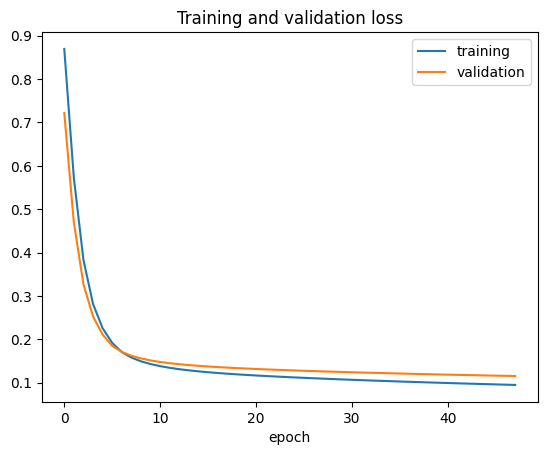

<Figure size 640x480 with 0 Axes>

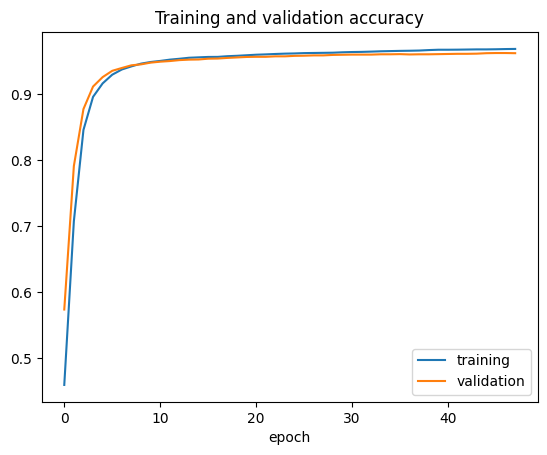

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [37]:
model_summary(model, history)

## **Evaluation on test set**

In [38]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...


C:\Users\velde\PycharmProjects\PythonProject3\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_468']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

C:\Users\velde\PycharmProjects\PythonProject3\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_468']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step


> Correct Predictions: 4034
> Wrong Predictions: 160


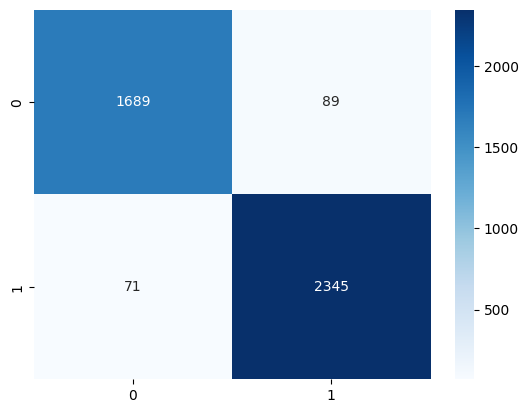

              precision    recall  f1-score   support

 NonViolence       0.96      0.95      0.95      1778
    Violence       0.96      0.97      0.97      2416

    accuracy                           0.96      4194
   macro avg       0.96      0.96      0.96      4194
weighted avg       0.96      0.96      0.96      4194



In [40]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, \
    confusion_matrix

corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.uint((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.uint((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred, annot=True, fmt="d", cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds,
                                    target_names=["NonViolence", "Violence"]))

In [43]:
args_model = "./my_model.keras"
model.save(args_model)